# Síťová analýza PID

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import collections
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
pid = pd.read_csv("d.csv")

## Předzpracování dat

Za jedinečný identifikátor zastávky můžete považovat **název zastávky**. Pozor na stejné názvy zastávek pro různé dopravní prostředky - u takových zastávek můžete uvažovat, že se jedná o jednu a tutéž stanici (v mnoha případech to i platí). 

In [3]:
pid.head()

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,U2991Z301,Hněvice,T58005,Hněvice seř.n.,4:53:00,4:54:30,2,0,1,1,1,1,1,0,0
1,T58005,Hněvice seř.n.,U4610Z301,Záluží,4:54:30,4:56:00,2,0,1,1,1,1,1,0,0
2,U4610Z301,Záluží,U4609Z301,Dobříň,4:56:00,4:59:00,2,0,1,1,1,1,1,0,0
3,U4609Z301,Dobříň,U4608Z301,Roudnice nad Labem,4:59:00,5:03:00,2,0,1,1,1,1,1,0,0
4,U4608Z301,Roudnice nad Labem,U4609Z301,Dobříň,4:36:00,4:38:00,2,0,1,1,1,1,1,0,0


In [4]:
def adjust_times(df, col):
    time_split = df[col].str.split(":", expand=True)
    hours = time_split[0].astype(int) % 24 
    minutes = time_split[1]
    seconds = time_split[2]

    df[col] = pd.to_datetime(
        hours.astype(str) + ":" +
        minutes + ":" +
        seconds,
        format="%H:%M:%S"
    ).dt.time
    return df

In [5]:
pid_copy = pid.copy()
pid_copy = adjust_times(pid_copy, "depart_from")
pid_copy = adjust_times(pid_copy, "arrive_to")
display(pid_copy.info())
pid_copy.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642433 entries, 0 to 1642432
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   stop_from       1642433 non-null  object
 1   stop_from_name  1642433 non-null  object
 2   stop_to         1642433 non-null  object
 3   stop_to_name    1642433 non-null  object
 4   depart_from     1642433 non-null  object
 5   arrive_to       1642433 non-null  object
 6   route_type      1642433 non-null  int64 
 7   is_night        1642433 non-null  int64 
 8   monday          1642433 non-null  int64 
 9   tuesday         1642433 non-null  int64 
 10  wednesday       1642433 non-null  int64 
 11  thursday        1642433 non-null  int64 
 12  friday          1642433 non-null  int64 
 13  saturday        1642433 non-null  int64 
 14  sunday          1642433 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 188.0+ MB


None

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,U2991Z301,Hněvice,T58005,Hněvice seř.n.,04:53:00,04:54:30,2,0,1,1,1,1,1,0,0
1,T58005,Hněvice seř.n.,U4610Z301,Záluží,04:54:30,04:56:00,2,0,1,1,1,1,1,0,0
2,U4610Z301,Záluží,U4609Z301,Dobříň,04:56:00,04:59:00,2,0,1,1,1,1,1,0,0
3,U4609Z301,Dobříň,U4608Z301,Roudnice nad Labem,04:59:00,05:03:00,2,0,1,1,1,1,1,0,0
4,U4608Z301,Roudnice nad Labem,U4609Z301,Dobříň,04:36:00,04:38:00,2,0,1,1,1,1,1,0,0


In [6]:
pid = pid_copy

## Základní síťová analýza

### Vizualizace podsítě

Vizualizuji síť tramvají. Popisky statnic nechám u koncových stanic a stanic, které kolem sebe nemají hodně dalších stanic a jejich název je kratší než 9 písmen (kvůli čitelnosti). Vrcholy jsou rozmístěny v grafu na základě geografické polohy z datasetu stops.csv. Pro vyřešení problému různých lokací zastávek se stejným názvem jsem zvolil zprůměrování poloh po složkách. Považuji tedy název za unikátní identifikátor. Z lokačních dat jsem vybral jen zastávky, které se týkají tramvají.

In [7]:
def initialize_graph(df):
    G = nx.DiGraph()

    for index, row in df.iterrows():
        stop_from = row['stop_from_name']
        stop_to = row['stop_to_name']
        weight = row['monday'] + row['tuesday'] + row['wednesday'] + row['thursday'] + row['friday'] + row['saturday'] + row['sunday']

        if G.has_edge(stop_from, stop_to):
            G[stop_from][stop_to]['weight'] += weight
        else:
            G.add_edge(stop_from, stop_to, weight=weight)
    return G

In [8]:
tram_df = pid[pid["route_type"] == 0] 
G_tram_subgraph = initialize_graph(tram_df)

In [9]:
def get_filtered_stops(filtered_df, stops):
    tram_stops = set(filtered_df['stop_from']).union(set(filtered_df['stop_to']))
    filtered_stops = stops[stops['stop_id'].isin(tram_stops)]
    return filtered_stops

def get_pos(filtered_df, stops):
    filtered_stops = get_filtered_stops(filtered_df, stops)
    mean_loc = filtered_stops.groupby("stop_name").apply(
        lambda x: pd.Series({
            "mean_lat": x["stop_lat"].mean(),
            "mean_lon": x["stop_lon"].mean()
        })
    ).reset_index()

    pos = mean_loc.set_index("stop_name")[["mean_lat", "mean_lon"]].to_dict("index")
    pos = {key: (value["mean_lon"], value["mean_lat"]) for key, value in pos.items()}
    return pos, mean_loc

In [10]:
stops = pd.read_csv("stops.csv")
pos, mean_loc = get_pos(tram_df, stops)

In [11]:
def display_graph(graph, ax ,node_color='lightblue', cmap=None):
    nx.draw_networkx(
        graph,
        pos=pos,
        ax=ax,
        node_size=60,
        node_color= node_color,
        edgecolors='black',  
        edge_color='#a0a0a0',
        arrowstyle='-|>',
        arrows=True,
        cmap=cmap,
        connectionstyle='arc3,rad=0.07',
        with_labels=False
    )
    ax.margins(0)
    ax.axis("off")

def get_end_stations(graph):
    end_nodes = []
    for node in graph.nodes:
        if graph.in_degree(node) == 1 and graph.out_degree(node) == 1:
            successors = list(graph.successors(node))
            predecessors = list(graph.predecessors(node))
            if successors == predecessors:
                if len(successors) == 1:
                    end_nodes.append(node)
    return set(end_nodes)

def get_alone_nodes(mean_loc, radius, max_count):
    coords = mean_loc[['mean_lon', 'mean_lat']].values
    nbrs = NearestNeighbors(radius=radius).fit(coords)
    distances, indices = nbrs.radius_neighbors(coords)

    filtered_nodes = []
    for i, neighbors in enumerate(indices):
        if len(neighbors) < max_count:  
            filtered_nodes.append(mean_loc.iloc[i]['stop_name'])
    return set(filtered_nodes)

def display_text(x,y,node, bold):
        radius = 0.0015
        angle = (3*np.pi)/2
        x_offset = radius * np.cos(angle)
        y_offset = radius * np.sin(angle)
        plt.text(
            x + x_offset, y + y_offset, node,
            fontsize=8,
            color='black',
            fontweight=bold
        )

def display_labels(filtered_nodes, end_stations, max_label_length, bold='normal'):
    for node in filtered_nodes:
        x,y = pos[node]
        if node in end_stations:
            if(node == "Sídliště Řepy"):
                x = x -0.01
                y = y -0.001
            display_text(x, y, node, bold)
        else:
            if len(node) < max_label_length:  
                display_text(x, y, node, bold)



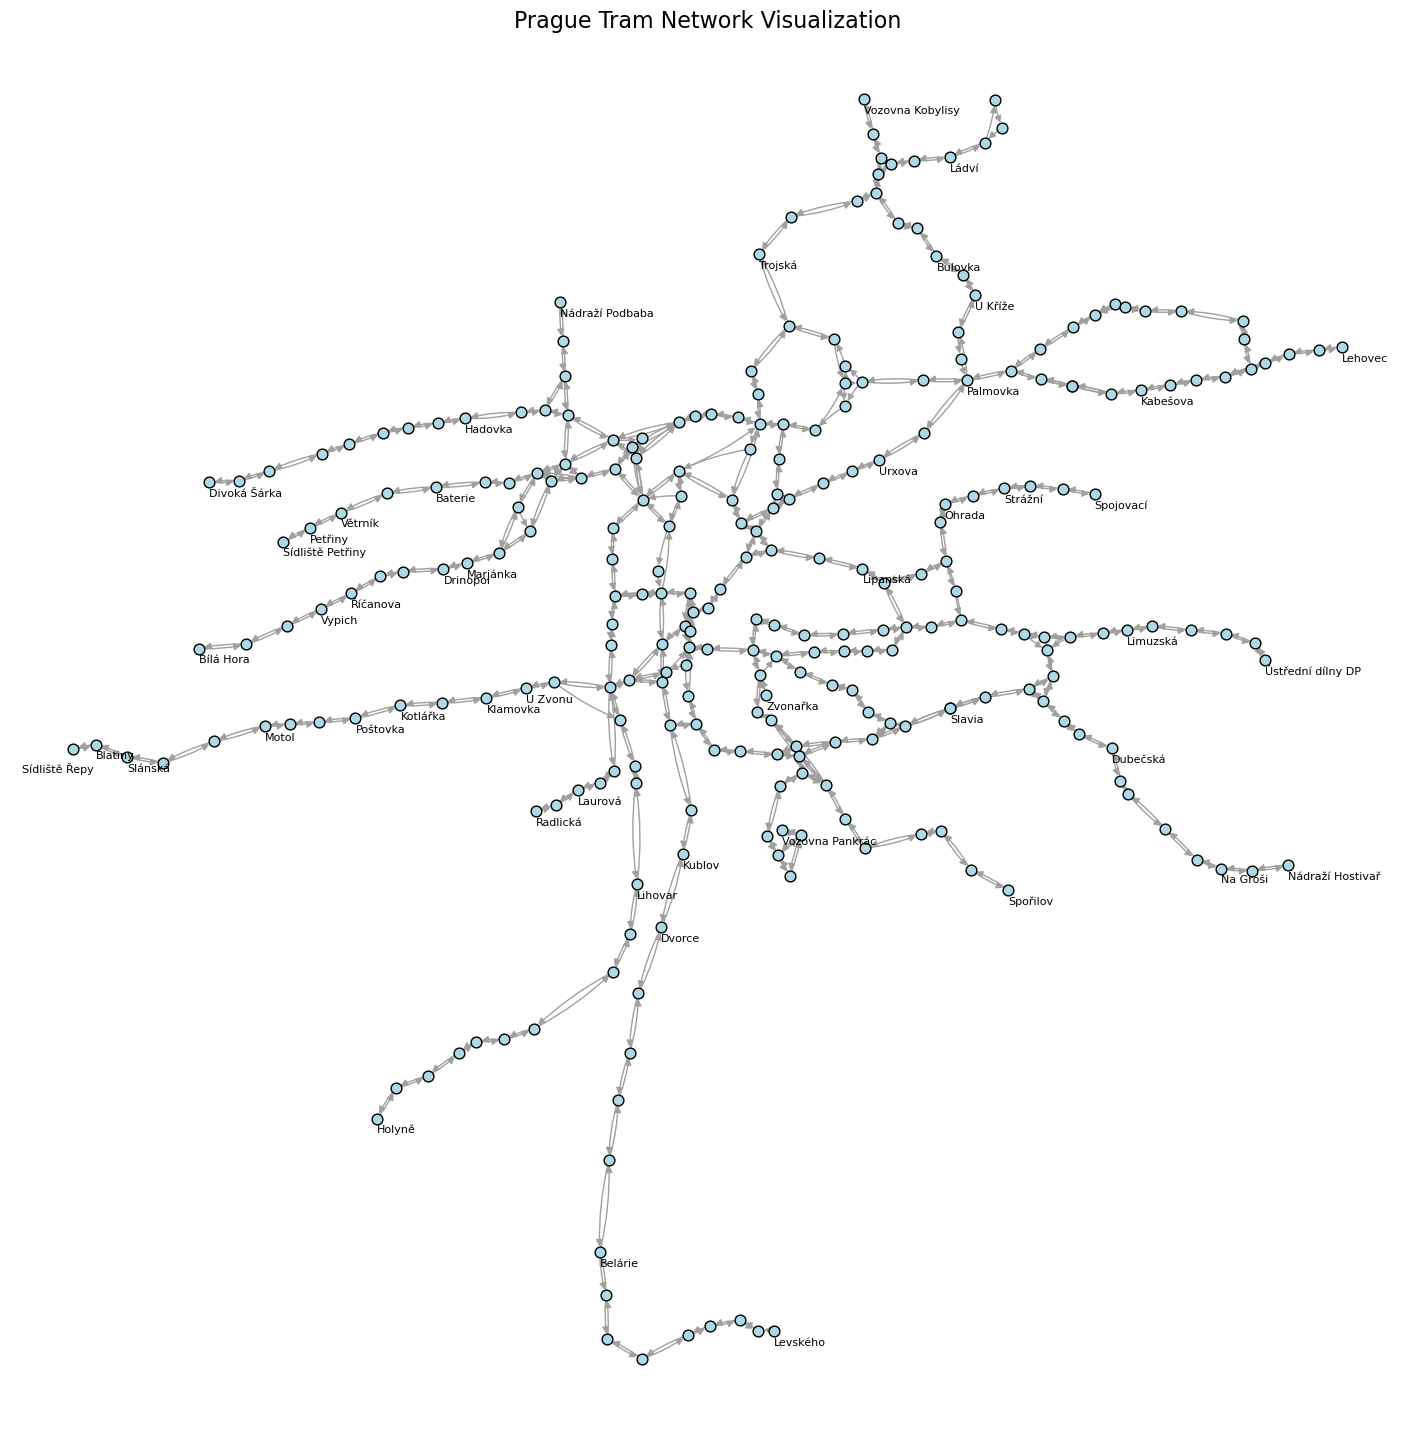

In [12]:
fig, ax = plt.subplots(figsize=(18, 18))

end_stations = get_end_stations(G_tram_subgraph)
alone_nodes = get_alone_nodes(mean_loc, 0.008, 5)

filtered_nodes = end_stations.union(alone_nodes)

display_graph(G_tram_subgraph, ax)

display_labels(filtered_nodes, end_stations, 9)

plt.title("Prague Tram Network Visualization", fontsize=16)
plt.show()

### Centralita mezilehlosti

Pomocí centrality mezilehlosti můžeme vizualizovat přes které zastávky vede nejvíce nejkratších cest mezi jinými zastávkami. Např kdybychom chtěli zjistit vliv na dopravu vyřazení zastávky z provozu.

In [13]:
between_centrality = dict(sorted(nx.betweenness_centrality(G_tram_subgraph).items(), key=lambda item: item[1], reverse=True))

In [14]:
def display_centrality(name,centrality, graph, ax):
    node_color = [centrality[node] for node in graph.nodes()]
    cmap = cm.get_cmap('viridis_r')
    norm = plt.Normalize(vmin=min(node_color), vmax=max(node_color))

    display_graph(graph, ax, node_color, cmap)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label=name, shrink=0.8, aspect=100) 

    plt.title(f"Graph Visualization with {name} (Color Scale)")

def display_table(name,centrality):
    print(f"Table of five stops with the largest {name}")
    centrality_df = pd.DataFrame(list(centrality.items()), columns=['Stop Name', f'{name}'])
    display(centrality_df.head().style.hide_index())

# def display_labels(centrality, graph, pos):
#     labels = {node: str(node) for node in list(centrality.keys())[:5]}
#     label_pos = {key: (value[0], value[1] + 0.001) for key, value in pos.items()}
#     nx.draw_networkx_labels(
#         graph, 
#         label_pos, 
#         labels=labels, 
#         font_size=9, 
#         font_color='black', 
#         font_weight='bold', 
#         bbox=dict(facecolor='white', edgecolor='none', alpha=0.2, boxstyle='round,pad=0.3')
#     )

Table of five stops with the largest Betweenness Centrality


Stop Name,Betweenness Centrality
Malostranská,0.341121
Národní divadlo,0.280907
Čechův most,0.270975
Staroměstská,0.266992
Strossmayerovo náměstí,0.250786


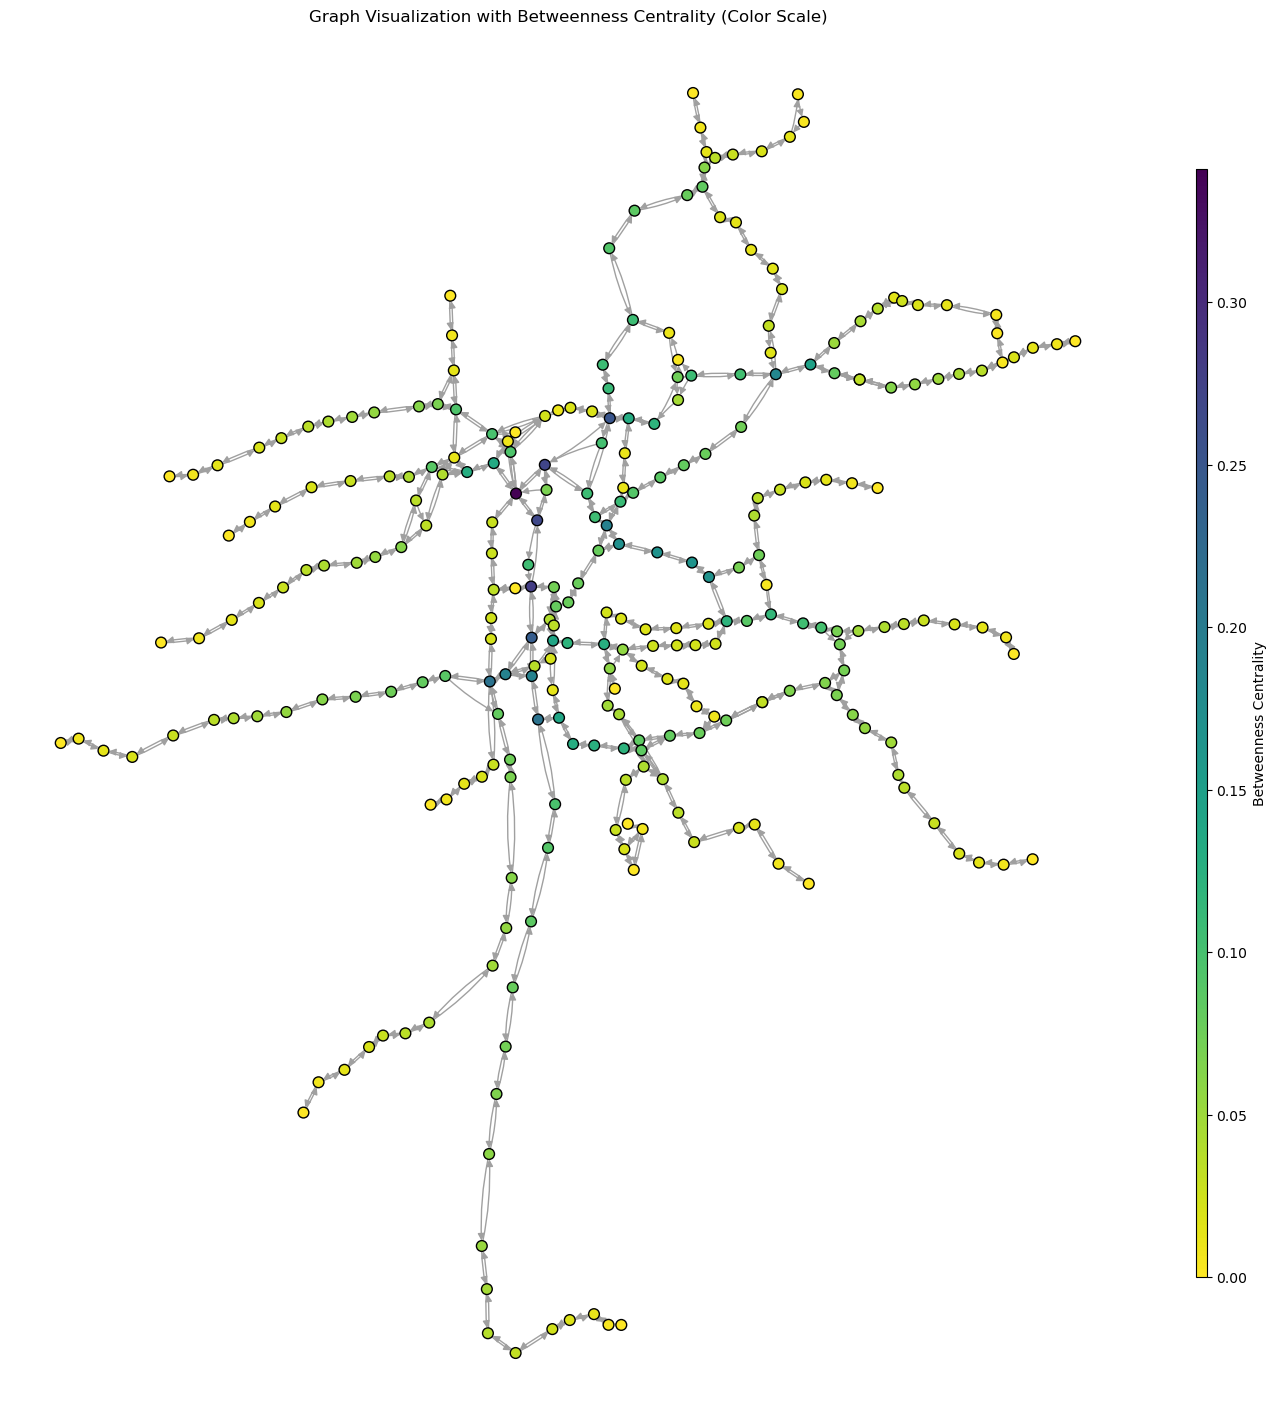

In [15]:
fig, ax = plt.subplots(figsize=(18, 18))

display_centrality('Betweenness Centrality', between_centrality, G_tram_subgraph, ax)
display_table('Betweenness Centrality', between_centrality)

plt.show()

### Stupňová centralita uzlu

Stupňová centralita nám pomůže odhalit zastávky, které jsou důležité pro správný provoz tramvajové sítě. Zastávky s vysokým stupněm mají hodně sousedů a můžou být tedy důležitým výstupním/nástupním bodem. Vizualizoval jsem jak autority tak huby.

In [16]:
in_degree_centrality = dict(sorted(nx.in_degree_centrality(G_tram_subgraph).items(), key=lambda item: item[1], reverse=True))
out_degree_centrality = dict(sorted(nx.out_degree_centrality(G_tram_subgraph).items(), key=lambda item: item[1], reverse=True))

Table of five stops with the largest in-degree Centrality


Stop Name,in-degree Centrality
Malostranská,0.025000
Karlovo náměstí,0.021429
Otakarova,0.021429
Náměstí Bratří Synků,0.021429
Anděl,0.017857


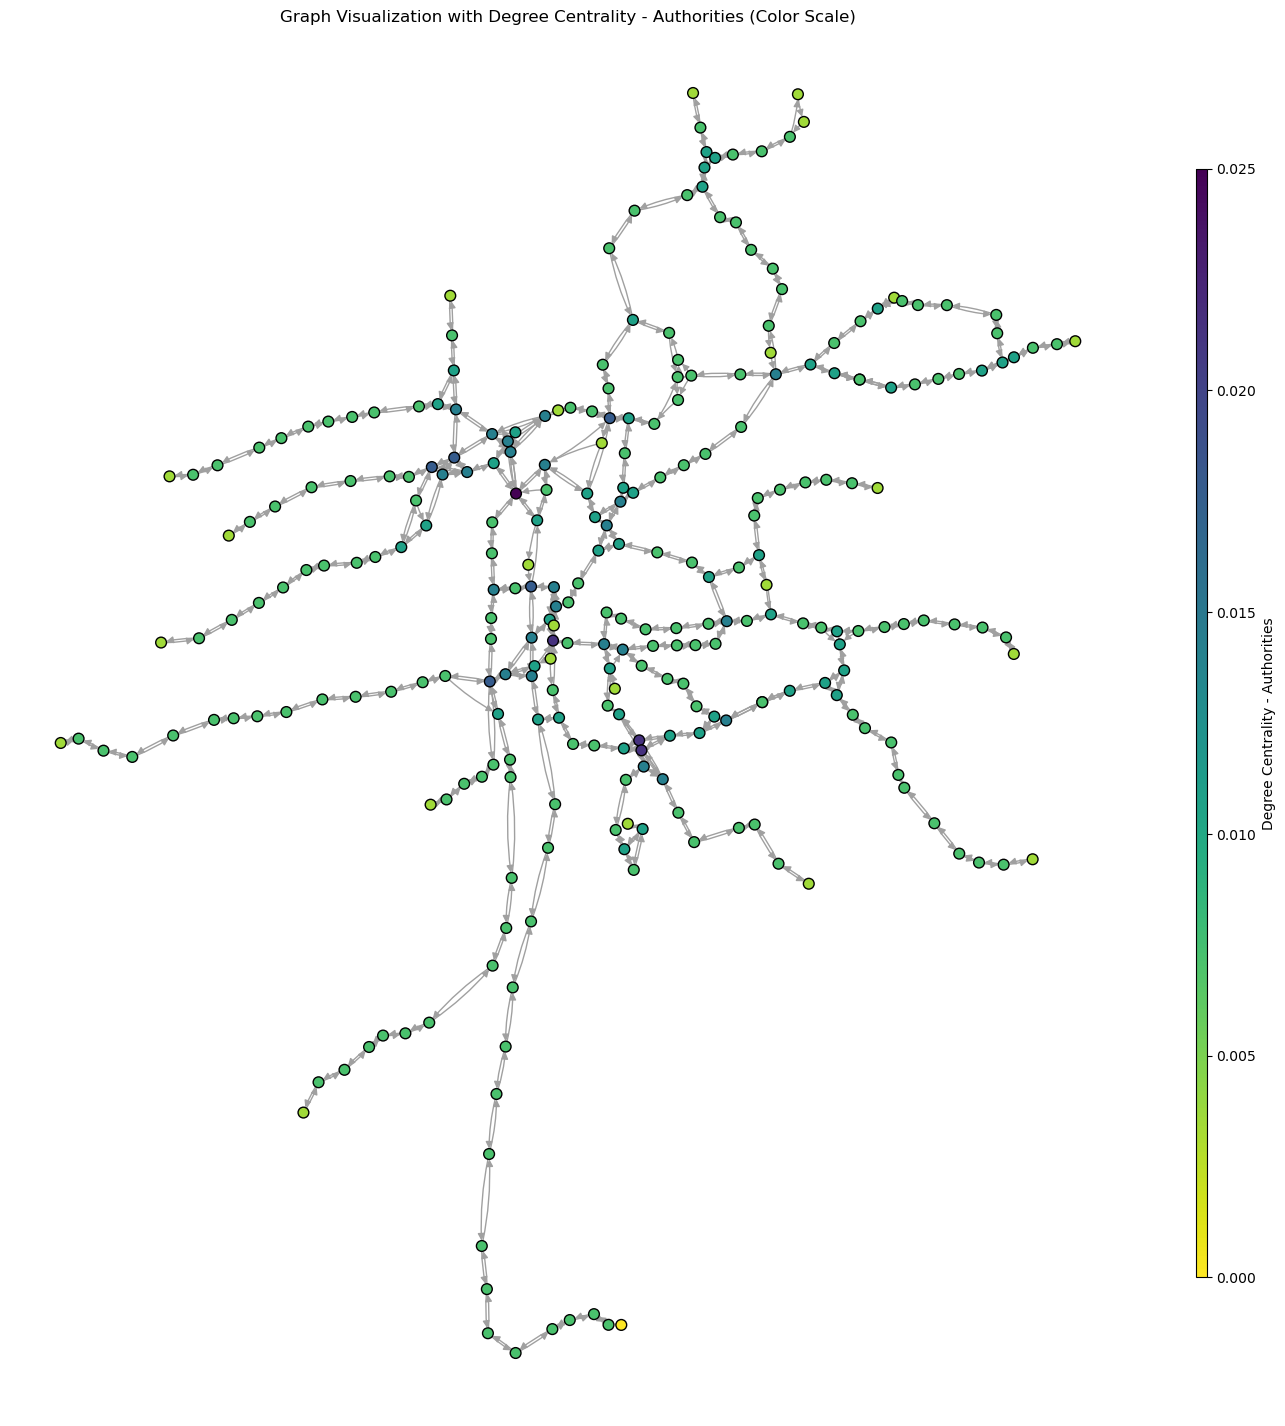

In [17]:
fig, ax = plt.subplots(figsize=(18, 18))

display_centrality('Degree Centrality - Authorities', in_degree_centrality, G_tram_subgraph, ax)
display_table('in-degree Centrality', in_degree_centrality)

plt.show()

Table of five stops with the largest out-degree Centrality


Stop Name,out-degree Centrality
Otakarova,0.021429
Náměstí Bratří Synků,0.021429
Malostranská,0.021429
Anděl,0.017857
Národní divadlo,0.017857


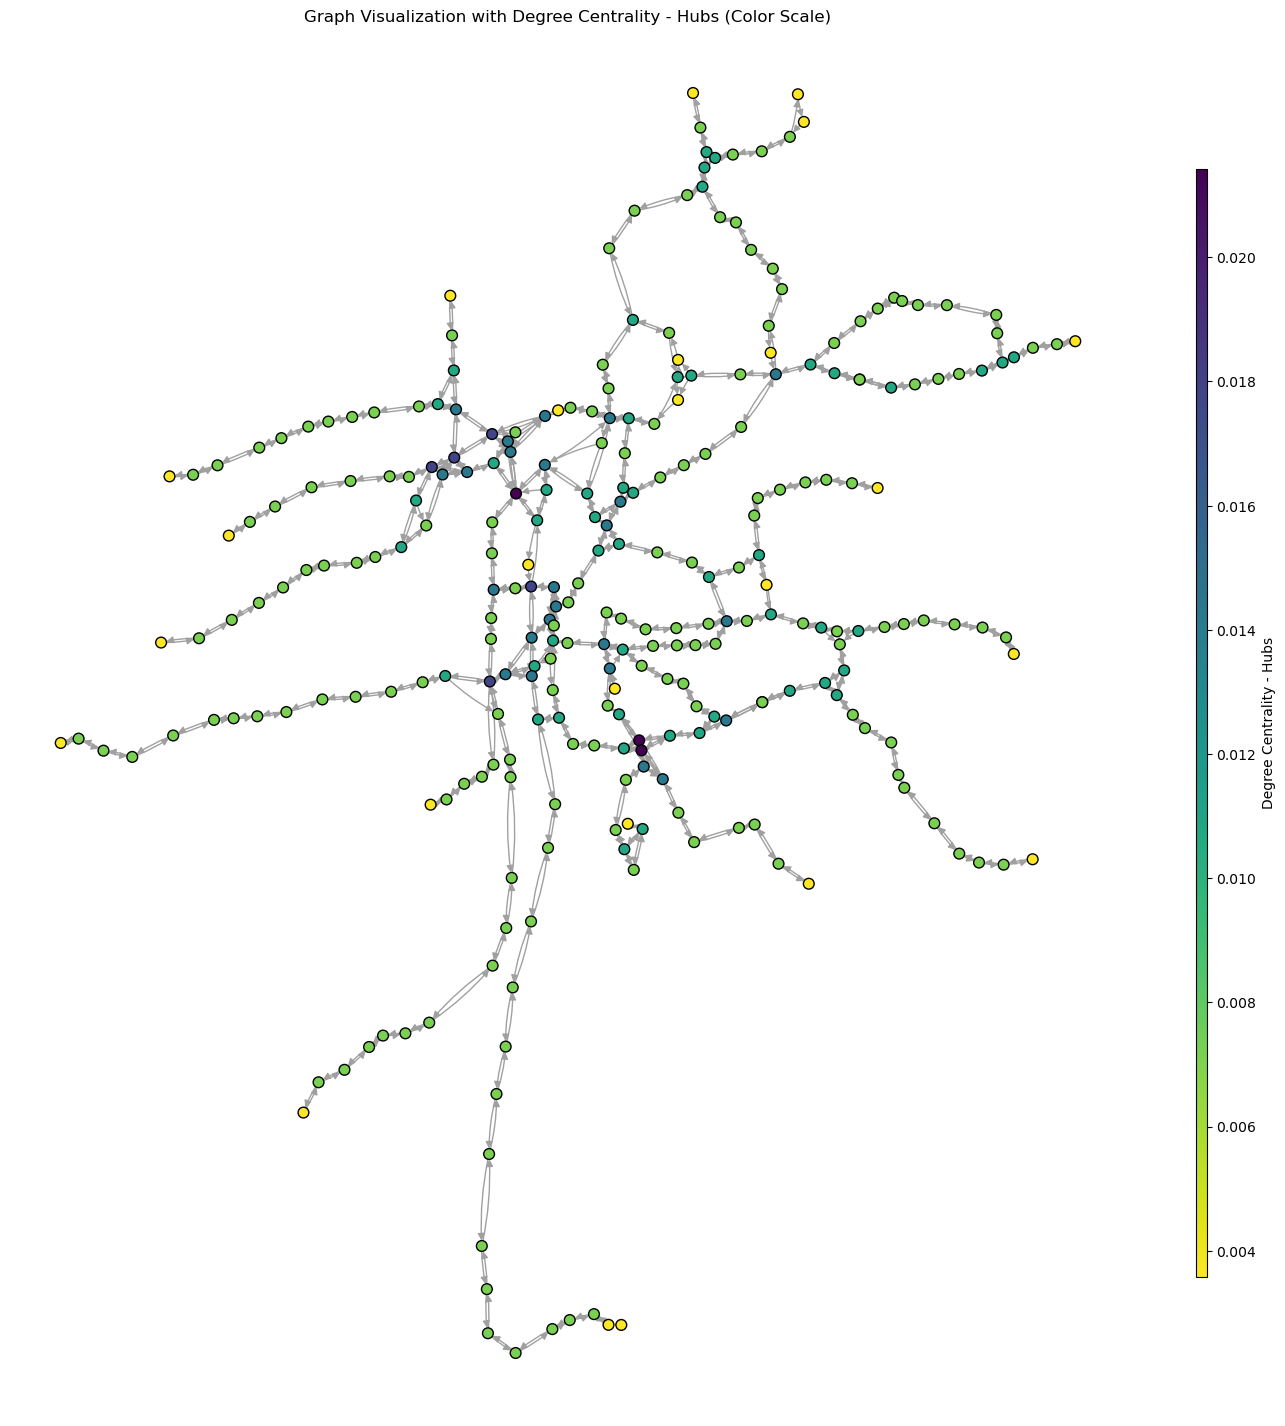

In [18]:
fig, ax = plt.subplots(figsize=(18, 18))

display_centrality('Degree Centrality - Hubs', out_degree_centrality, G_tram_subgraph, ax)
display_table('out-degree Centrality', out_degree_centrality)

plt.show()

### Centralita blízkosti

Centralita blízkosti nám ukazuje jak dobře (jak daleko) je dosažitelný zbytek sítě z dané zastávky. 

In [19]:
#.reverse(), closeness_centrality uses inward distance
out_closeness_centrality = dict(sorted(nx.closeness_centrality(G_tram_subgraph.reverse()).items(), key=lambda item: item[1], reverse=True)) 

Table of five stops with the largest Closeness Centrality


Stop Name,Closeness Centrality
Národní divadlo,0.098374
Jiráskovo náměstí,0.097204
Národní třída,0.095797
Malostranská,0.095665
Čechův most,0.094495


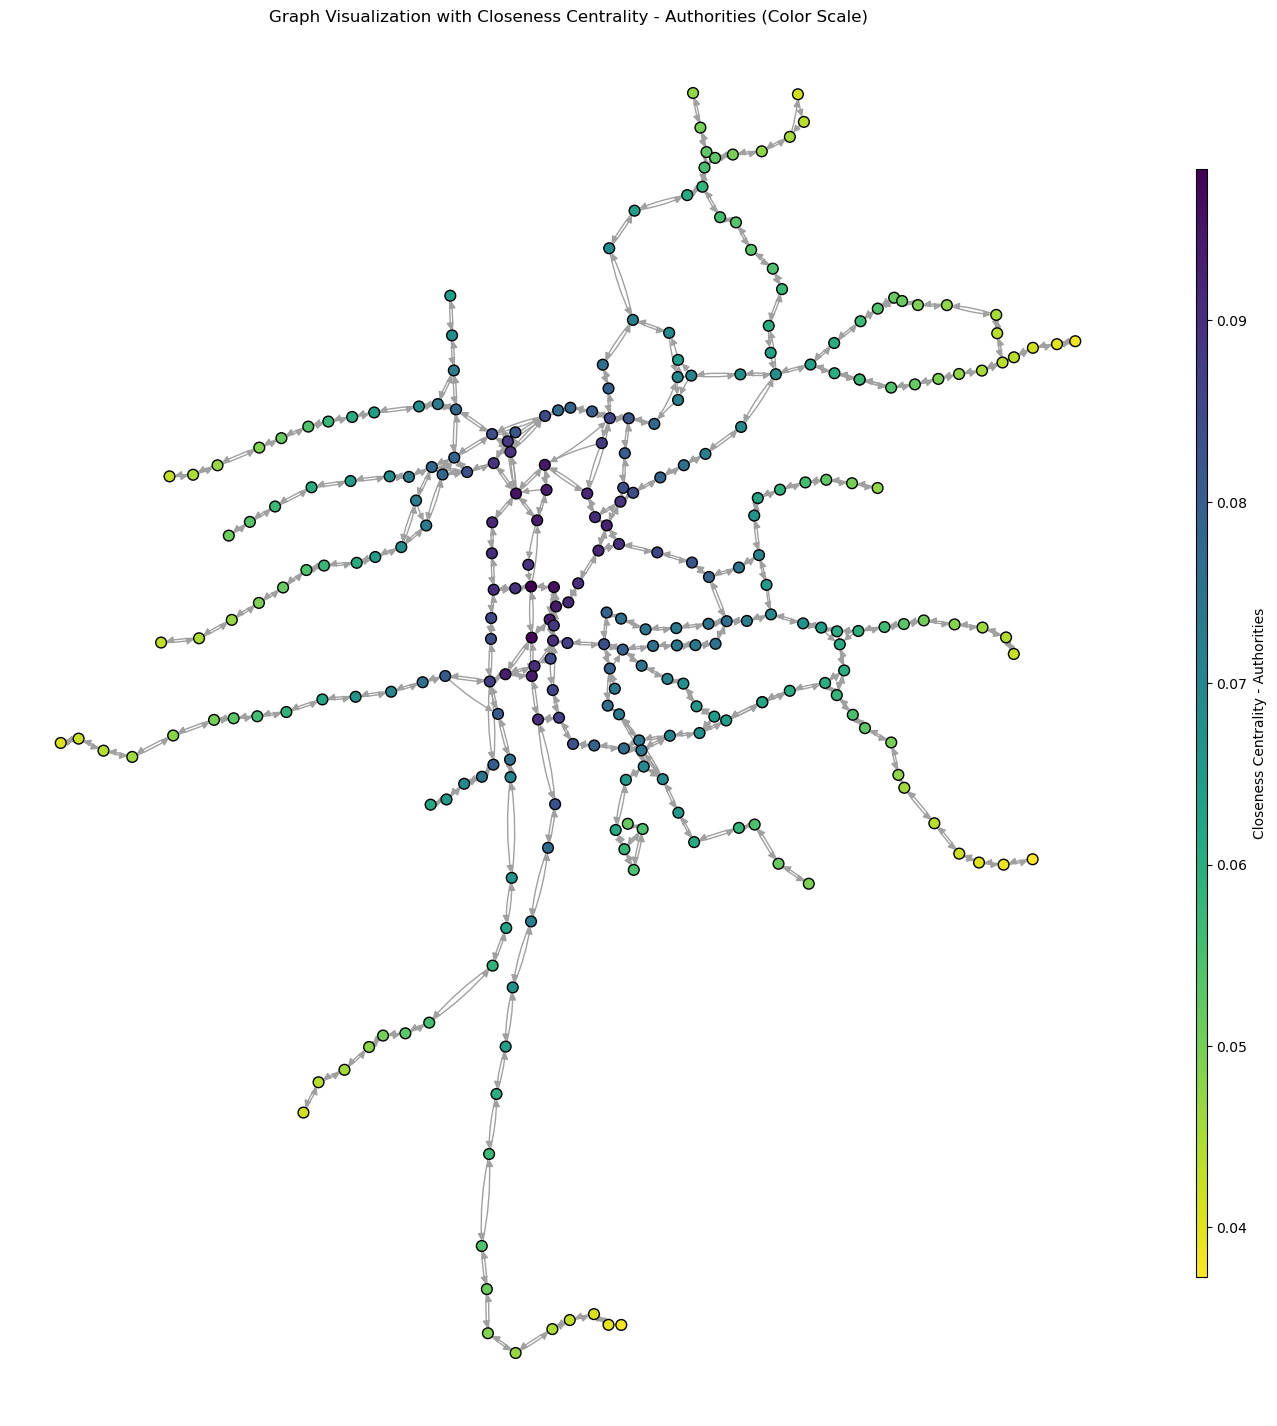

In [20]:
fig, ax = plt.subplots(figsize=(18, 18))

display_centrality('Closeness Centrality - Authorities', out_closeness_centrality, G_tram_subgraph, ax)
display_table('Closeness Centrality', out_closeness_centrality)
plt.show()

## Vlastní otázky

1. Jaké a kolik je zastávek, které jsou nemají možnost nástupu pro invalidy?
2. Jak se liší množství spojů ve všední den ráno (6:00 - 9:30) a o víkendu?
3. TODO - Koeficient shlukovani? maybe?

- Musí být založené na filtraci datasetu + váha hran, jak to vizulalizovat?
- Jaký je, něco s tou váhou?

In [21]:
stops.head()

,stop_id,stop_name,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,wheelchair_boarding,level_id,platform_code,asw_node_id,asw_stop_id
0,U50S1,Budějovická,50.044411,14.448787,P,NaN,1,NaN,1,NaN,NaN,50.0,NaN
1,U52S1,Chodov,50.031672,14.490961,P,NaN,1,NaN,1,NaN,NaN,52.0,NaN
2,U75S1,Kolbenova,50.110395,14.516398,P,NaN,1,NaN,1,NaN,NaN,75.0,NaN
3,U78S1,Ládví,50.126591,14.469451,P,NaN,1,NaN,1,NaN,NaN,78.0,NaN
4,U100S1,Vltavská,50.100298,14.438492,P,NaN,1,NaN,1,NaN,NaN,100.0,NaN


In [22]:
pid.head()

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,U2991Z301,Hněvice,T58005,Hněvice seř.n.,04:53:00,04:54:30,2,0,1,1,1,1,1,0,0
1,T58005,Hněvice seř.n.,U4610Z301,Záluží,04:54:30,04:56:00,2,0,1,1,1,1,1,0,0
2,U4610Z301,Záluží,U4609Z301,Dobříň,04:56:00,04:59:00,2,0,1,1,1,1,1,0,0
3,U4609Z301,Dobříň,U4608Z301,Roudnice nad Labem,04:59:00,05:03:00,2,0,1,1,1,1,1,0,0
4,U4608Z301,Roudnice nad Labem,U4609Z301,Dobříň,04:36:00,04:38:00,2,0,1,1,1,1,1,0,0


### Jaké a kolik je zastávek, které jsou nemají možnost nástupu pro invalidy?

Ze zastávek vyfiltrujeme pouze ty, které mají nějaké nástupiště s možností nástupu invalidů. Červeně zobrazím ty, které nemají možnost nástupu invalidů

In [30]:
tram_stops = get_filtered_stops(tram_df, stops)
accessible_stops = set(tram_stops[tram_stops['wheelchair_boarding'] == 1]['stop_name'].unique())
inaccessible_stops = set(tram_stops[tram_stops['wheelchair_boarding'] != 1]['stop_name'].unique()).difference(accessible_stops)

In [31]:
tram_wheel_df = tram_df[tram_df['stop_from_name'].isin(accessible_stops) & tram_df['stop_to_name'].isin(accessible_stops)]
G_tram_wheel_subgraph = initialize_graph(tram_df)
for stop in inaccessible_stops:
        G_tram_wheel_subgraph.add_node(stop)

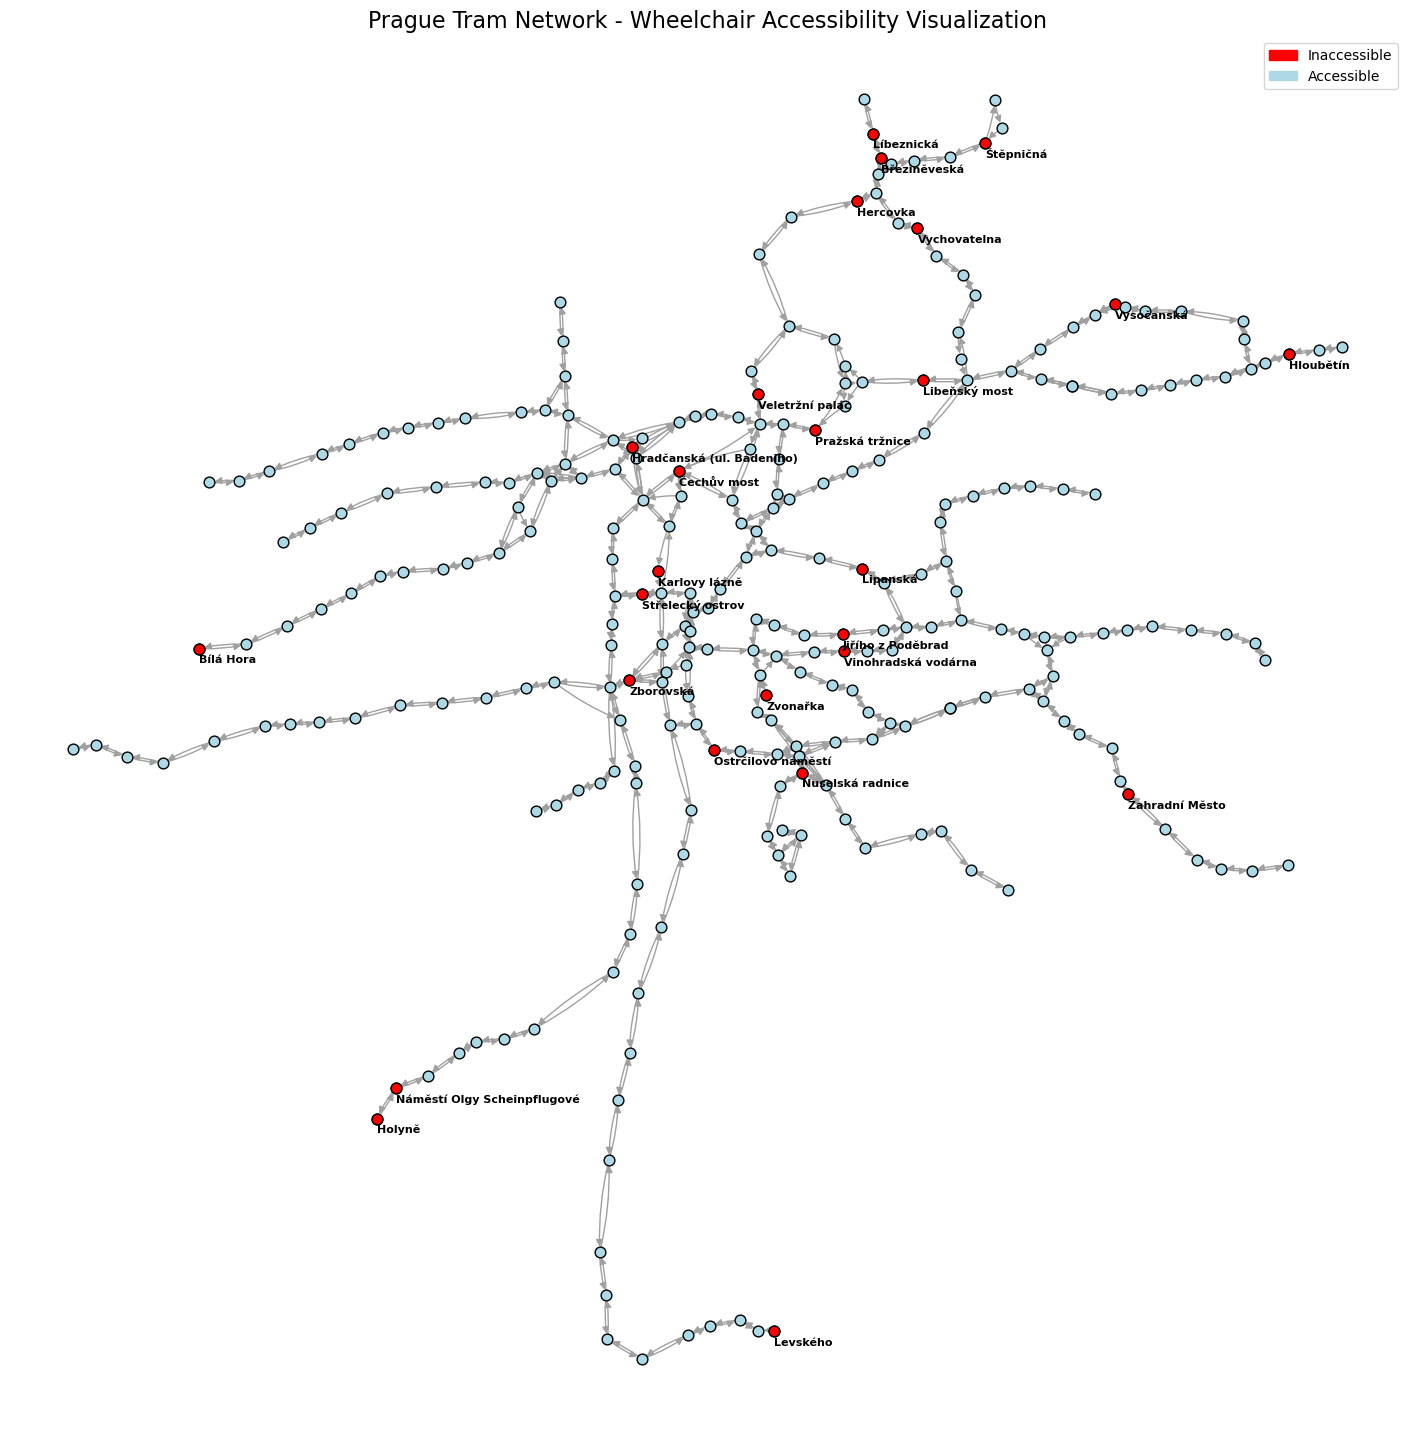

In [32]:
fig, ax = plt.subplots(figsize=(18, 18))

display_graph(G_tram_wheel_subgraph, ax)

nx.draw_networkx_nodes(G_tram_wheel_subgraph, pos=pos, nodelist=inaccessible_stops, node_color='red', node_size=60, edgecolors='black')

display_labels(inaccessible_stops, set(), 30, 'bold')
red_patch = mpatches.Patch(color='red', label='Inaccessible')
blue_patch = mpatches.Patch(color='lightblue', label='Accessible')
plt.legend(handles=[red_patch, blue_patch], loc='best')
plt.title("Prague Tram Network - Wheelchair Accessibility Visualization", fontsize=16)
plt.show()

### Jak se liší množství spojů ve všední den ráno (6:00 - 9:30) a o víkendu?

Nejprve vyfiltruji příslušná data a vytvořím grafy.

In [26]:
work_trams = tram_df[
    ((tram_df['monday'] == 1) |
    (tram_df['tuesday'] == 1) |
    (tram_df['wednesday'] == 1) |
    (tram_df['thursday'] == 1) |
    (tram_df['friday'] == 1)) &
    ((tram_df['saturday'] == 0) &
    (tram_df['sunday'] == 0)) &
    (tram_df['depart_from'] >= pd.to_datetime('06:00:00').time()) &
    (tram_df['depart_from'] <= pd.to_datetime('09:30:00').time())
]

weekend_trams = tram_df[
    ((tram_df['monday'] == 0) &
    (tram_df['tuesday'] == 0) &
    (tram_df['wednesday'] == 0) &
    (tram_df['thursday'] == 0) &
    (tram_df['friday'] == 0)) &
    ((tram_df['saturday'] == 1) |
    (tram_df['sunday'] == 1)) &
    (tram_df['depart_from'] >= pd.to_datetime('06:00:00').time()) &
    (tram_df['depart_from'] <= pd.to_datetime('09:30:00').time())
]

In [27]:
G_work_tram_subgraph = initialize_graph(work_trams)
G_weekend_tram_subgraph = initialize_graph(weekend_trams)

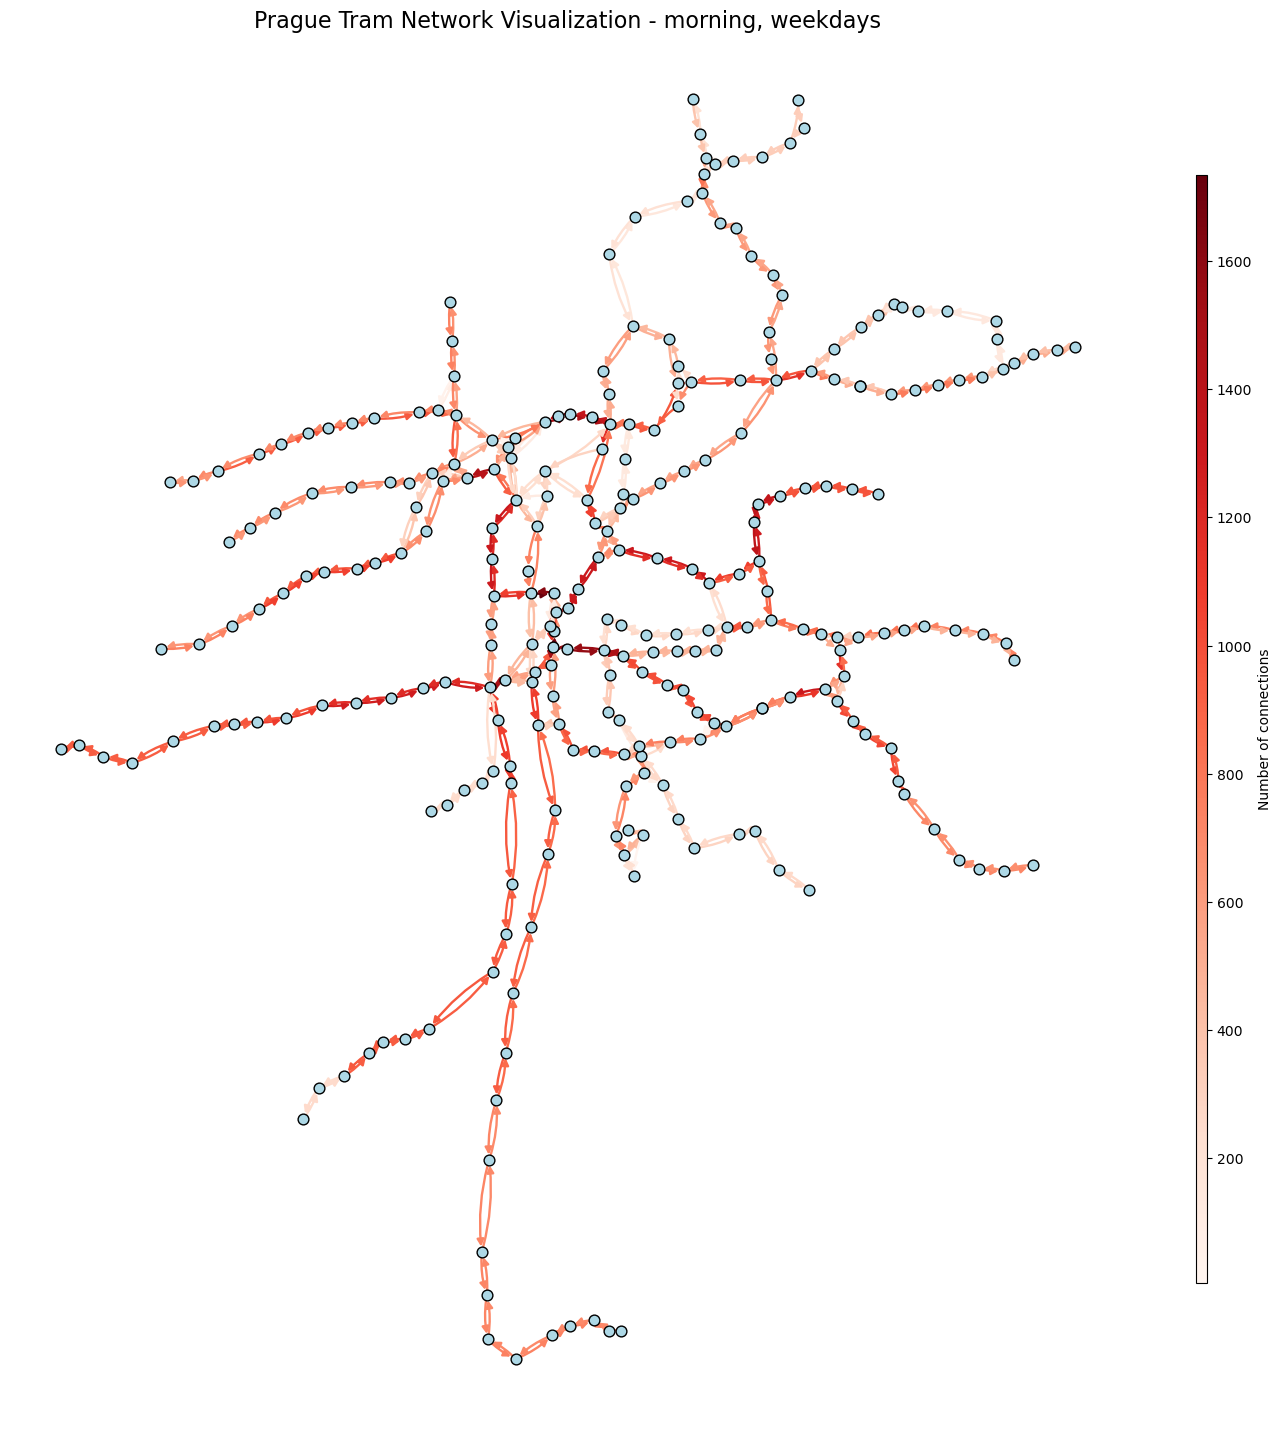

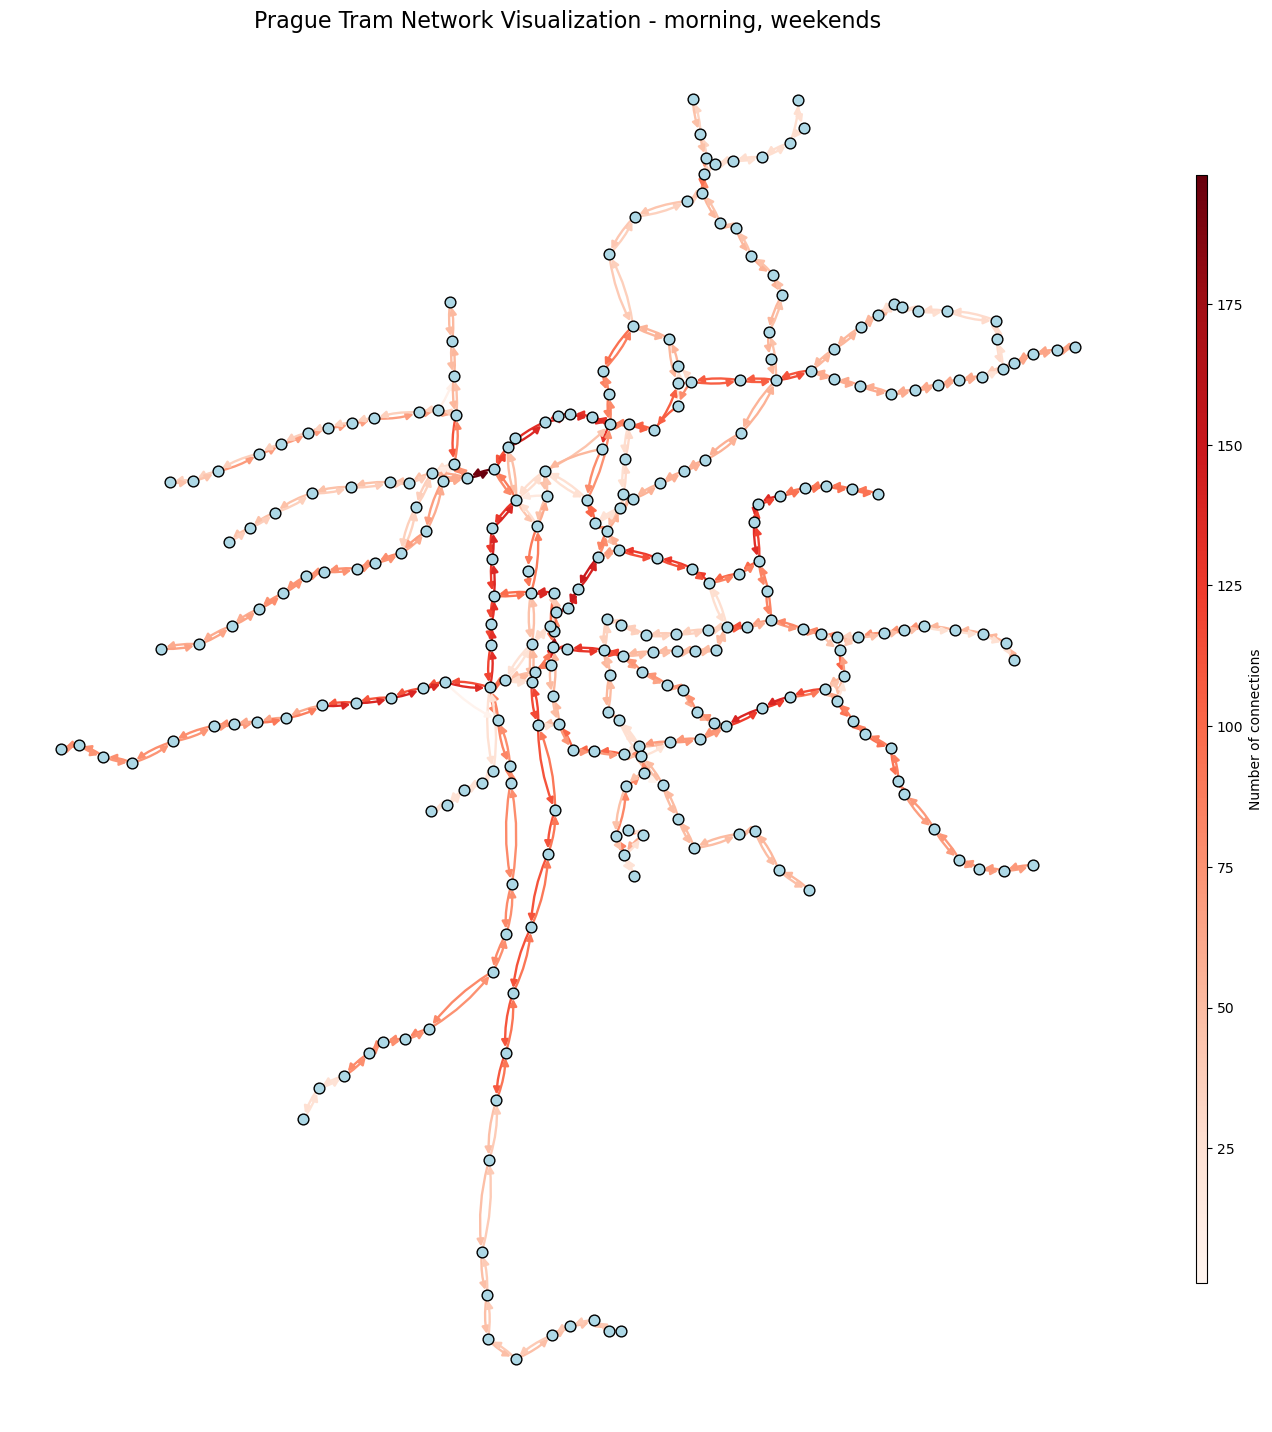

In [33]:
fig, ax = plt.subplots(figsize=(18, 18))

edges, weights = zip(*nx.get_edge_attributes(G_work_tram_subgraph, 'weight').items())
norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
colors = [cm.Reds(w / max(weights)) for w in weights]
nx.draw_networkx(
    G_work_tram_subgraph,
    pos=pos,
    ax=ax,
    node_size=60,
    node_color= 'lightblue',
    edgecolors='black',
    edgelist=edges,
    edge_color=colors,
    width=1.7,
    connectionstyle='arc3,rad=0.1',
    with_labels=False
)
sm = plt.cm.ScalarMappable(cmap=cm.Reds, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Number of connections', shrink=0.8, aspect=100) 
plt.axis('off')
plt.margins(0)
plt.title("Prague Tram Network Visualization - morning, weekdays", fontsize=16)
plt.show()

fig, ax = plt.subplots(figsize=(18, 18))

edges, weights = zip(*nx.get_edge_attributes(G_weekend_tram_subgraph, 'weight').items())
norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
colors = [cm.Reds(w / max(weights)) for w in weights]
nx.draw_networkx(
    G_weekend_tram_subgraph,
    pos=pos,
    ax=ax,
    node_size=60,
    node_color= 'lightblue',
    edgecolors='black',
    edgelist=edges,
    edge_color=colors,
    width=1.7,
    connectionstyle='arc3,rad=0.1',
    with_labels=False
)
sm = plt.cm.ScalarMappable(cmap=cm.Reds, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Number of connections', shrink=0.8, aspect=100) 
plt.axis('off')
plt.margins(0)
plt.title("Prague Tram Network Visualization - morning, weekends", fontsize=16)
plt.show()

In [29]:
# # Vizualization in one figure for comparison
# fig, axes = plt.subplots(1,2, figsize=(40, 20), constrained_layout=True)

# edges_weekday, weights_weekday = zip(*nx.get_edge_attributes(G_work_tram_subgraph, 'weight').items())
# edges_weekend, weights_weekend = zip(*nx.get_edge_attributes(G_weekend_tram_subgraph, 'weight').items())

# all_weights = list(weights_weekday) + list(weights_weekend)
# norm = plt.Normalize(vmin=min(all_weights), vmax=max(all_weights))

# colors_weekday = [cm.Reds(w / max(all_weights)) for w in weights_weekday]
# colors_weekend = [cm.Reds(w / max(all_weights)) for w in weights_weekend]

# # Draw Weekday
# nx.draw_networkx(
#     G_work_tram_subgraph,
#     pos=pos,
#     ax=axes[0],
#     node_size=60,
#     node_color='lightblue',
#     edgecolors='black',
#     edgelist=edges_weekday,
#     edge_color=colors_weekday,
#     width=1.7,
#     connectionstyle='arc3,rad=0.1',
#     with_labels=False
# )
# axes[0].set_title("Prague Tram Network Visualization - morning, weekdays", fontsize=20)
# axes[0].axis('off')

# # Draw Weekend
# nx.draw_networkx(
#     G_weekend_tram_subgraph,
#     pos=pos,
#     ax=axes[1],
#     node_size=60,
#     node_color='lightblue',
#     edgecolors='black',
#     edgelist=edges_weekend,
#     edge_color=colors_weekend,
#     width=1.7,
#     connectionstyle='arc3,rad=0.1',
#     with_labels=False
# )
# axes[1].set_title("Prague Tram Network Visualization - morning, weekends", fontsize=20)
# axes[1].axis('off')

# sm = plt.cm.ScalarMappable(cmap=cm.Reds, norm=norm)
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, shrink=0.3)
# cbar.set_label('Number of connections', fontsize=14)

# plt.margins(0)
# plt.show()

Z grafů je patrné, že víkendový provoz ráno je mnohem menší, než přes pracovní týden (i po úvažení, že v týdnu je více dnů). Jednotlivé spoje mezi zastávakami v týdnu a o víkendu jsou relativně vůči sobě stejně vytížené.

### Třetí otázka